# Pullback Approach

# Setup Libraries

In [1]:
import pandas as pd
import numpy as np
import os, sys
from talib.abstract import MACD, STOCH, MA

sys.path.append(os.path.join(os.path.dirname('__file__'), '..', 'Scripts'))
from func import rolling_max_dd, max_dd, altmaxdd, ConLoss, ConWin

# Suppresses SettingWithCopyWarning in Pandas
pd.options.mode.chained_assignment = None  # default='warn'

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Get Testing Data

In [2]:
# Copy-paste historical data under variable data
data = "EURUSD-2010_01_01-2018_06_12" + ".csv"
market = "../Historical data/" + str(data) #input duka data here

# time
df = pd.read_csv(market, index_col='time')
df.index = pd.Index(pd.to_datetime(df.index)).tz_localize('UTC').tz_convert('EET')

# Set Parameters

In [3]:
Don_S = 20                
Don_SX = 10               
Don_L = 500               
#incl_chan = False         

MACD_param = (12, 26, 9)  
SMA_Fast = 20             
SMA_Slow = 50             
Pip_Diff = 5            # Pip difference for entry (standard: 3)
Pip_Diff_SL = 5           

## Indicators

In [4]:
df2 = pd.DataFrame()

#DC10 & DC20 
df2['Don_S_U']   = df.high.rolling(window=Don_S,center=False).max()                               
df2['Don_S_L']   = df.low.rolling(window=Don_S,center=False).min()                                
df2['Don_SX_U']  = df.high.rolling(window=Don_SX,center=False).max()                              
df2['Don_SX_L']  = df.low.rolling(window=Don_SX,center=False).min()                               

#DC500 mid-line
df2['Don_L_M']   = (df.high.rolling(window=Don_L,center=False).max() + \
                   df.low.rolling(window=Don_L,center=False).min()) / 2                           

#MACD Histogram
df2['MACD_Hist'] = MACD(df, *MACD_param)['macdhist']                                             

#SMA crossover
df2['SMA_diff']  = MA(df, SMA_Fast) - MA(df, SMA_Slow)                                            

#Buy/Sell zone  
incl_chan_buy    = lambda: df2.Don_S_L > df2.Don_L_M  
incl_chan_sell   = lambda: df2.Don_S_U < df2.Don_L_M 

## Condition Setup and Raw Backtest Results

**LONG**

In [5]:
df_long = pd.DataFrame(index=df.index) 
df_long['open'] = df.open

df_long['BuyStop'] = np.where(df2.MACD_Hist.shift(1) < 0, 
                              df2.Don_S_U.shift(1) + Pip_Diff*0.0001, None)                               # Change pip to be compatible with JPY & USDMXN
df_long['BuyStop'].fillna(method='ffill', inplace=True)                                                   

# Buy Signal Setup
buy_sig1 = lambda: df.high                                            
buy_sig2 = lambda: df_long.BuyStop                                     
rbuy_sig3 = lambda: df.low                                              
rbuy_sig4 = lambda: df2.Don_SX_L.shift(1) - Pip_Diff_SL*0.0001        

# Buy Signals
df_long['BuySig'] = np.where(buy_sig1() > df_long.BuyStop, 1, 0)                                          
df_long['BuySig'] = np.where(buy_sig2() > df_long.open, df_long.BuySig, 0)
df_long['BuySig'] = np.where(df_long.BuySig & (df2.SMA_diff.shift(1) > 0), 1, 0)                          
df_long['BuySig'] = np.where(df_long.BuySig & incl_chan_buy().shift(1), 1, 0)  

# MACD Pullback region
df_long['macd'] = np.where((df2.MACD_Hist.shift(2) > 0) & (df2.MACD_Hist.shift(1) < 0), 1, 0)
df_long['macd'] = df_long['macd'].cumsum()

# Unstacking such that limit to one trade per macd region
df_long['BuySig'] = np.where((df_long['BuySig']) & 
                             ((df_long['macd'] == df_long['macd'].shift(1)) | (df_long['macd'] != df_long['macd'].shift(1)))
                            , 1, None)
df_long['BuySig'] = np.where(df_long['macd'].shift(1) == df_long['macd']
                             , np.where(df_long['BuySig'].shift(1) == 1,None, df_long['BuySig']), 0)
df_long['BuySig'].fillna(method='ffill', inplace=True)
df_long['BuySig'] = np.where((df_long.BuySig == 1) & (df_long['macd'].shift(1) == df_long['macd'])
                             , np.where(df_long['BuySig'].shift(1) + df_long['BuySig'] == 2 ,0, df_long['BuySig'])
                             , 0)



df_long['BuySig_price'] = np.where(df_long.BuySig == 1, buy_sig2(), 0) 




df_long['CurrentSL'] = df2.Don_SX_L.shift(1) - Pip_Diff_SL*0.0001
df_long['CurrentSL'] = np.where(df_long.open > df_long.CurrentSL,
                                 df_long.CurrentSL, df_long.BuySig_price - Pip_Diff_SL*0.0001) # issue 13 possible solution
#df_long['CurrentSL'] = np.where(df_long.BuySig_price - df_long.CurrentSL > Pip_Diff_SL*0.0001,
#                                 df_long.CurrentSL, df_long.BuySig_price - Pip_Diff_SL*0.0001)


# Stop Loss
df_long['StopLoss'] = np.where(rbuy_sig3() < df_long.CurrentSL, 
                              rbuy_sig4(), None)     
df_long['StopLoss'].fillna(method='bfill', inplace=True)                                                  
df_long['StopLoss'].fillna(value=df.close[-1], inplace=True)                                              


# Trade Duration
df_long['StopLoss_time'] = pd.to_datetime(np.where(rbuy_sig3() < df_long.CurrentSL, 
                                          df.index, None)).tz_localize('UTC').tz_convert('EET')
df_long['StopLoss_time'].fillna(method='bfill', inplace=True)                                             
df_long['StopLoss_time'].fillna(value=df.index[-1], inplace=True)  

#df_long[df_long['BuySig'] == 1]

**SHORT**

In [6]:
df_short = pd.DataFrame(index=df.index)
df_short['open'] = df.open

df_short['SellStop'] = np.where(df2.MACD_Hist.shift(1) > 0, 
                               df2.Don_S_L.shift(1) - Pip_Diff*0.0001, None)                             # Change pip to be compatible with JPY & USDMXN
df_short['SellStop'].fillna(method='ffill', inplace=True)

# Sell Signal Setup
sell_sig1 = lambda: df.low
sell_sig2 = lambda: df_short.SellStop
rsell_sig3 = lambda: df.high
rsell_sig4 = lambda: df2.Don_SX_U.shift(1) + Pip_Diff_SL*0.0001

# Sell Signals
df_short['SellSig'] = np.where(sell_sig1() < df_short.SellStop, 1, 0)   
df_short['SellSig'] = np.where(sell_sig2() < df_short.open, df_short.SellSig, 0)
df_short['SellSig'] = np.where(df_short.SellSig & (df2.SMA_diff.shift(1) < 0), 1, 0)                     
df_short['SellSig'] = np.where(df_short.SellSig & incl_chan_sell().shift(1), 1, 0)      

# MACD Pullback region
df_short['macd'] = np.where((df2.MACD_Hist.shift(2) < 0) & (df2.MACD_Hist.shift(1) > 0), 1, 0)
df_short['macd'] = df_short['macd'].cumsum()

# Unstacking such that limit to one trade per macd region
df_short['SellSig'] = np.where((df_short['SellSig']) & 
                             ((df_short['macd'] == df_short['macd'].shift(1)) | (df_short['macd'] != df_short['macd'].shift(1)))
                            , 1, None)
df_short['SellSig'] = np.where(df_short['macd'].shift(1) == df_short['macd']
                             , np.where(df_short['SellSig'].shift(1) == 1,None, df_short['SellSig']), 0)
df_short['SellSig'].fillna(method='ffill', inplace=True)
df_short['SellSig'] = np.where((df_short.SellSig == 1) & (df_short['macd'].shift(1) == df_short['macd'])
                             , np.where(df_short['SellSig'].shift(1) + df_short['SellSig'] == 2 ,0, df_short['SellSig'])
                             , 0)



df_short['SellSig_price'] = np.where(df_short.SellSig == 1, sell_sig2(), 0)




df_short['CurrentSL'] = df2.Don_SX_U.shift(1) + Pip_Diff_SL*0.0001
df_short['CurrentSL'] = np.where(df_short.open > df_short.CurrentSL,
                                 df_short.CurrentSL, df_short.SellSig_price + Pip_Diff_SL*0.0001) #issue 13 possible solution
#df_short['CurrentSL'] = np.where(df_short.SellSig_price - df_short.CurrentSL > Pip_Diff_SL*0.0001,
#                                 df_short.CurrentSL, df_short.SellSig_price + Pip_Diff_SL*0.0001)



# Stop Loss
df_short['StopLoss'] = np.where(rsell_sig3() > df_short.CurrentSL, 
                               rsell_sig4(), None)
df_short['StopLoss'].fillna(method='bfill', inplace=True)                                             
df_short['StopLoss'].fillna(value=df.close[-1], inplace=True)                                         


# Trade Duration
df_short['StopLoss_time'] = pd.to_datetime(np.where(rsell_sig3() > df_short.CurrentSL, 
                            df.index, None)).tz_localize('UTC').tz_convert('EET')
df_short['StopLoss_time'].fillna(method='bfill', inplace=True)
df_short['StopLoss_time'].fillna(value=df.index[-1], inplace=True)    

#df_short[df_short['SellSig'] == 1]

**STATISTICS**

In [7]:
df_stats = pd.DataFrame(index=df.index)

df_stats['Signal'] = np.where(df_long.BuySig | df_short.SellSig, 1, 0)

# Pip GainLoss
df_stats['BuyProfits']  = np.where(df_long.BuySig, 
                                   df_long.StopLoss - df_long.BuySig_price, 0)                           

df_stats['SellProfits'] = np.where(df_short.SellSig, 
                                   -(df_short.StopLoss - df_short.SellSig_price), 0)                     

df_stats['Profits'] = df_stats.BuyProfits + df_stats.SellProfits                                         

df_stats['CumSum'] = df_stats.Profits.cumsum()



# % of Initial Balance (Also Risk-Reward Ratio)
df_stats['BuyProfits_R'] = np.where(df_long.BuySig, 
                                    df_stats.BuyProfits/
                                    (df_long.BuySig_price - df_long.CurrentSL), 0)                    

df_stats['SellProfits_R'] = np.where(df_short.SellSig, 
                                    df_stats.SellProfits/
                                    -(df_short.SellSig_price - df_short.CurrentSL), 0)

df_stats['Profits_R'] = (df_stats.BuyProfits_R + df_stats.SellProfits_R) * 0.01


df_stats['CumSum_R'] = df_stats.Profits_R.cumsum()  


df_stats['Profits_Perc'] = df_stats.Profits_R + 1
df_stats['CumProd_R'] = df_stats.Profits_Perc.cumprod()

df_stats = df_stats[df_stats.Signal == 1]
#del df_stats['Signal']


#calculating no. of years for CAGR
D0 = (df.index[0])
D1 = (df.index[-1])
DA = str(D1-D0)
DL = int(DA[:4])
Year = DL/365.25   

## Equity Graphs

In [8]:
#plt.figure()
#df_stats['CumSum'].plot()                                               # Pipsize equity graph

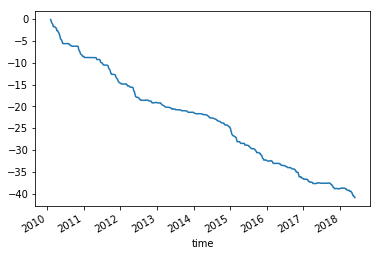

In [9]:
plt.figure()
df_stats['CumSum_R'].plot()                                             # Risk-based equity graph (% of initial balance)

## Equity Graph Manipulation on Risk Equity Curves

In [10]:
new_df = pd.DataFrame(index=df_stats.index)
new_df['CumSum'] = df_stats.CumSum_R                                    
new_df['MA_CumSum'] = new_df.CumSum.rolling(10).mean()                  # 10-period equity curve moving average

<Figure size 432x288 with 0 Axes>

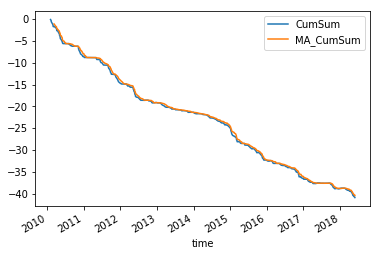

In [11]:
plt.figure()
new_df.plot()

## Partial Results

In [12]:
# non-reversal results
new_df['NewProfits_0'] = np.where(new_df.CumSum.shift(1) > new_df.MA_CumSum.shift(1), 
                                df_stats.Profits_R, 0)                                               

# reversal results
new_df['NewProfits_2'] = np.where(new_df.CumSum.shift(1) > new_df.MA_CumSum.shift(1), 
                                0, -df_stats.Profits_R)                                              

# full strategy results
new_df['NewProfits'] = np.where(new_df.CumSum.shift(1) > new_df.MA_CumSum.shift(1), 
                                df_stats.Profits_R, -df_stats.Profits_R)                             


# first 10 trades voided for moving average
new_df['NewProfits_0'][:10] = 0                                                                 
new_df['NewProfits_2'][:10] = 0  
new_df['NewProfits'][:10] = 0

new_df['NewCumSum_0']  = new_df.NewProfits_0.cumsum()                                                
new_df['NewCumSum_2']  = new_df.NewProfits_2.cumsum()                                                
new_df['NewCumSum']  = new_df.NewProfits.cumsum()                                                    


                                                                 

print("No reversal # of live trades:      {}".format(
    new_df.NewProfits_0[new_df.NewProfits_0 != 0].count()))                                                                                

print("Reversal # of live trades:         {}".format(
    new_df.NewProfits_2[new_df.NewProfits_2 != 0].count()))  

print("Total # of trades:                 {}".format(new_df.NewProfits_0.count()))    
print("Average # of trades per year:      {:.0f}".format(new_df.NewProfits_0.count()/Year))    

No reversal # of live trades:      65
Reversal # of live trades:         612
Total # of trades:                 687
Average # of trades per year:      81


**Non-reversal stats**

In [13]:
print("No reversal return:    {:.02f}%".format(new_df.NewCumSum_0[-1]*100))           # ending P/L of non-reversal
print("No reversal max DD:    {:.02f}%".format(max_dd(new_df.NewCumSum_0)*100))

maxCL_0 = max(ConLoss(new_df['NewProfits_0']))
print("Max consecutive losses: {}".format(maxCL_0))
maxCW_0 = max(ConWin(new_df['NewProfits_0']))
print("Max consecutive wins: {}".format(maxCW_0))

No reversal return:    -84.60%
No reversal max DD:    96.50%
Max consecutive losses: 4
Max consecutive wins: 5


**Reversal stats**

In [14]:
print("Reversal return:       {:.02f}%".format(new_df.NewCumSum_2[-1]*100))           # ending P/L of reversal
print("Reversal max dd:       {:.02f}%".format(max_dd(new_df.NewCumSum_2)*100))
maxCL_2 = max(ConLoss(new_df['NewProfits_2']))
print("Max consecutive losses: {}".format(maxCL_2))
maxCW_2 = max(ConWin(new_df['NewProfits_2']))
print("Max consecutive wins: {}".format(maxCW_2))

Reversal return:       3815.69%
Reversal max dd:       13.63%
Max consecutive losses: 4
Max consecutive wins: 54


**Full reversal stats**

In [15]:
print("Full reversal return:  {:.02f}%".format(new_df.NewCumSum[-1]*100))             # ending P/L of full strategy
print("Full reversal max dd:  {:.02f}%".format(max_dd(new_df.NewCumSum)*100))
maxCL_3 = max(ConLoss(new_df['NewProfits']))
print("Max consecutive losses: {}".format(maxCL_3))
maxCW_3 = max(ConWin(new_df['NewProfits']))
print("Max consecutive wins: {}".format(maxCW_3))

Full reversal return:  3731.08%
Full reversal max dd:  27.99%
Max consecutive losses: 5
Max consecutive wins: 54


In [16]:
CAGR = (((1+new_df.NewCumSum[-1])/1)**(1/(Year)))-1

#Taking currency name as variable
Mkt = market.split('/')[-1].split('-')[0]                     
print("[{}]".format(Mkt))

print("CAGR:    {:.02f}%".format(CAGR*100))
print("Max DD:  {:.02f}%".format(max_dd(new_df.NewCumSum)*100))

MAR = CAGR/max_dd(new_df.NewCumSum)
print("MAR:     {:.02f}".format(MAR))

maxCL = max(ConLoss(new_df['NewProfits']))
print("Max consecutive losses: {}".format(maxCL))
maxCW = max(ConWin(new_df['NewProfits']))
print("Max consecutive wins: {}".format(maxCW))

[EURUSD]
CAGR:    54.00%
Max DD:  27.99%
MAR:     1.93
Max consecutive losses: 5
Max consecutive wins: 54


## Antimartingale EXC

**Combined exit SL time**

In [17]:
# getting the combined SL Time of long and short
df_time = pd.DataFrame(df_long.StopLoss_time)

df_time.columns = ['long']
df_time.long = str(df_time.long)
df_time['Longsig'] = df_long.BuySig

df_time['short'] = df_short.StopLoss_time
df_time.short = str(df_time.short)
df_time['Shortsig'] = df_short.SellSig

df_time = df_time[df_time.Shortsig | df_time.Longsig == 1]
df_time['combined'] = np.where(df_time['Longsig'] == 1, df_time['long'], 
                          np.where(df_time['Shortsig'] == 1, df_time['short'], 0))
#df_time

**Conloss adjusted for same exit time**

In [18]:
# Non-reversal Conloss
df_NR = pd.DataFrame(new_df.NewProfits_0)
df_NR['SLtime'] = df_time.combined
df_NR['losscount'] = np.where((df_NR['SLtime'] != df_NR['SLtime'].shift(1))
                               & (df_NR['NewProfits_0'].shift(1) < 0) , -1, 0)
df_NR['ConLossNRAMP'] = ConLoss(df_NR['losscount'])


# Reversal Conloss
df_RE = pd.DataFrame(new_df.NewProfits_2)
df_RE['SLtime'] = df_time.combined
df_RE['losscount'] = np.where((df_RE['SLtime'] != df_RE['SLtime'].shift(1))
                               & (df_RE['NewProfits_2'].shift(1) < 0) , -1, 0)
df_RE['ConLossRAMP'] = ConLoss(df_RE['losscount'])

**Anti-martingale for conloss**

In [19]:
# Anti-martingale (consecutive halving) after Equity MA, exclude loss count of different mode

new_df['NonReversalAntiMart'] = new_df.NewProfits_0*0.5**df_NR.ConLossNRAMP.shift(1)

new_df['ReversalAntiMart'] = new_df.NewProfits_2*0.5**df_RE.ConLossRAMP.shift(1)

new_df['AntiMartProfits_1'] = (new_df['NonReversalAntiMart'] + new_df['ReversalAntiMart'])
new_df['AntiMartProfits_1'][:10] = 0   

new_df['NewCumSum_4']= new_df.AntiMartProfits_1.cumsum()

print("Antimartingale EXC return:     {:.02f}%".format(new_df.NewCumSum_4[-1]*100))   
print("Antimartingale EXC max dd:     {:.02f}%".format(max_dd(new_df.NewCumSum_4)*100))

#(new_df.NewCumSum_4[-1]/(new_df.AntiMartProfits_1[new_df.AntiMartProfits_1 != 0].count()))/0.0001

Antimartingale EXC return:     3695.40%
Antimartingale EXC max dd:     27.99%


**DD threshold position sizing**

In [20]:
strategy = new_df.AntiMartProfits_1 
strategycs = new_df.NewCumSum_4 

df_PS = pd.DataFrame(strategycs)
df_PS.columns = ['Equity']
df_PS.Equity = df_PS.Equity + 1

# counting a complete loss series
df_PS['PnL'] = strategy
df_PS['Series'] = np.where((df_PS['PnL'].shift(1) <0) & (df_PS['PnL'] >0), 1, 0)

# rolling max drawdown
df_PS['Peak'] = df_PS.Equity.cummax()
df_PS['diff'] = df_PS.Peak - df_PS.Equity 
df_PS['Drawdown'] = df_PS['diff'].rolling(30).max() # rolling window

del df_PS['Equity']


df_PS['SerCS'] = df_PS['Series'].cumsum()

#counting the CL series within a running drawdown
df_PS['DDchg'] = np.where(df_PS.Drawdown != df_PS.Drawdown.shift(1), 1, 0)
df_PS['DDchg'] = np.where(df_PS.DDchg == 1, df_PS.SerCS, None)
df_PS['DDchg'].fillna(method= 'ffill', inplace = True)
df_PS['DDchg'].fillna(value = 0, inplace = True)   # to remove?
df_PS['DDchg'] = np.where(df_PS.DDchg > df_PS.DDchg.shift(1), df_PS.DDchg - df_PS.DDchg.shift(1), None)
df_PS['DDchg'].fillna(method= 'bfill', inplace = True)
df_PS['DDchg'].fillna(value = 0, inplace = True)
df_PS['DDchg'] = np.where(df_PS.DDchg == 0, 1, df_PS.DDchg) # to not let preset dd divide by 0

In [21]:
# Drawdown hits 15%, resets at 10%
df_PS['Thres1'] = np.where(df_PS.Drawdown.shift(1) > 0.05
         , 1, np.where((df_PS.Drawdown.shift(1) < 0.03) & (df_PS.Drawdown.shift(2) > 0.03), 0, None))
df_PS['Thres1'].fillna(method='ffill', inplace=True) 


new_df['DDthreshold'] = df_PS['Thres1']


new_df['AntiMartProfits_2'] = np.where(new_df.DDthreshold == 1, new_df.AntiMartProfits_1 * 0.5, new_df.AntiMartProfits_1)
new_df['NewCumSum_5']= new_df.AntiMartProfits_2.cumsum()

In [22]:
CAGR = (((new_df.NewCumSum_4[-1]+1)/1)**(1/(Year)))-1

print("[{}] Antimartingale EXC".format(Mkt))

print("CAGR:    {:.02f}%".format(CAGR*100))

print("Max DD:  {:.02f}%".format(max_dd(new_df.NewCumSum_4)*100))

MAR = CAGR/max_dd(new_df.NewCumSum_4)
print("MAR:     {:.02f}".format(MAR))


maxCL4 = max(ConLoss(new_df['AntiMartProfits_1']))
print("Max consecutive losses: {}".format(maxCL4))
maxCW4 = max(ConWin(new_df['AntiMartProfits_1']))
print("Max consecutive wins: {}".format(maxCW4))

print("Alternate Max DD: {:.02f}%".format(altmaxdd(new_df.NewCumSum_4)*100))

print("Antimartingale EXC total # of live trades: {}".format(new_df.AntiMartProfits_1[new_df.AntiMartProfits_1 != 0].count()))

[EURUSD] Antimartingale EXC
CAGR:    53.83%
Max DD:  27.99%
MAR:     1.92
Max consecutive losses: 5
Max consecutive wins: 54
Alternate Max DD: 5.71%
Antimartingale EXC total # of live trades: 677


In [23]:
CAGR = (((new_df.NewCumSum_5[-1]+1)/1)**(1/(Year)))-1

print("[{}] Antimartingale EXC2".format(Mkt))

print("CAGR:    {:.02f}%".format(CAGR*100))

print("Max DD:  {:.02f}%".format(max_dd(new_df.NewCumSum_5)*100))

MAR = CAGR/max_dd(new_df.NewCumSum_5)
print("MAR:     {:.02f}".format(MAR))


#maxCL4 = max(ConLoss(new_df['AntiMartProfits_2']))
#print("Max consecutive losses: {}".format(maxCL4))
#maxCW4 = max(ConWin(new_df['AntiMartProfits_2']))
#print("Max consecutive wins: {}".format(maxCW4))

print("Alternate Max DD: {:.02f}%".format(altmaxdd(new_df.NewCumSum_5)*100))

print("Antimartingale EXC total # of live trades: {}".format(new_df.AntiMartProfits_2[new_df.AntiMartProfits_2 != 0].count()))
print("Antimartingale EXC return:     {:.02f}%".format(new_df.NewCumSum_5[-1]*100))   

[EURUSD] Antimartingale EXC2
CAGR:    48.96%
Max DD:  19.86%
MAR:     2.46
Alternate Max DD: 1.41%
Antimartingale EXC total # of live trades: 677
Antimartingale EXC return:     2793.07%


<Figure size 432x288 with 0 Axes>

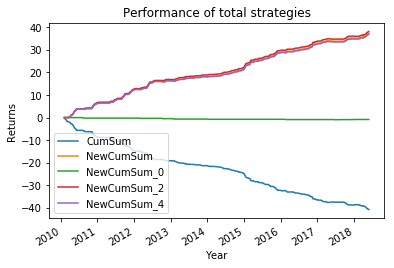

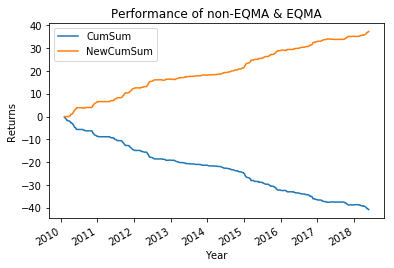

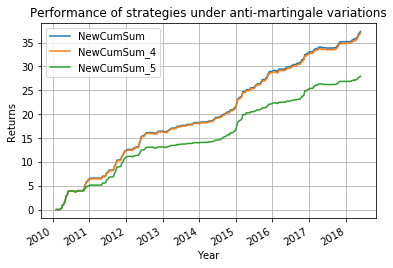

In [24]:
plt.figure()
new_df[['CumSum','NewCumSum', 
        'NewCumSum_0', 'NewCumSum_2','NewCumSum_4']].plot()
plt.title("Performance of total strategies")
plt.xlabel("Year")
plt.ylabel("Returns")
plt.grid(False)

new_df[['CumSum', 
        'NewCumSum']].plot()
plt.title("Performance of non-EQMA & EQMA")
plt.xlabel("Year")
plt.ylabel("Returns")

new_df[['NewCumSum', 'NewCumSum_4', 'NewCumSum_5']].plot()
plt.title("Performance of strategies under anti-martingale variations")
plt.xlabel("Year")
plt.ylabel("Returns")
plt.grid(True)

**Legend**
- cumsum = normal ,without ma
- newcumsum_0 = no reversal
- newcumsum_2 = reversal only
- newcumsum = full reversal (combined)
- newcumsum_4 = newcumsum on antimartingale EXC
- newcumsum_5 = EXC with normalisation after conwin 2

In [25]:
df_print = pd.DataFrame(index=df_stats.index)
df_print['BuySig'] = df_long.BuySig
df_print['SellSig'] = df_short.SellSig
df_print['Position'] = np.where(df_print.BuySig == 1, 'Buy',
                                np.where(df_print.SellSig == 1,
                                             'Sell',
                                             None))
df_print['BuySigPrice']  = df_long.BuySig_price
df_print['SellSigPrice'] = df_short.SellSig_price
df_print['OpeningPrice'] = np.where(df_print.BuySigPrice != 0,
                                    df_print.BuySigPrice,
                                    np.where(df_print.SellSigPrice != 0,
                                             df_print.SellSigPrice,
                                             None))
df_print['BuySL']    = df_long.CurrentSL[df_long.BuySig == 1]
df_print['SellSL']   = df_short.CurrentSL[df_short.SellSig == 1]
df_print['StopLoss'] = np.where(df_print.BuySigPrice != 0,
                                df_print.BuySL,
                                np.where(df_print.SellSigPrice != 0,
                                         df_print.SellSL,
                                         None))
df_print['BuyClosePr'] = df_long.StopLoss[df_long.BuySig == 1]
df_print['SellClosePr'] = df_short.StopLoss[df_short.SellSig == 1]
df_print['BuyClosePr_Time'] = df_long.StopLoss_time[df_long.BuySig == 1]
df_print['SellClosePr_Time'] = df_short.StopLoss_time[df_short.SellSig == 1]
df_print['ClosePriceTime'] = pd.to_datetime(
                             np.where(df_print.BuySigPrice != 0,
                                      df_print.BuyClosePr_Time,
                                      np.where(df_print.SellSigPrice != 0,
                                               df_print.SellClosePr_Time,
                                               None))
                             ).tz_localize('UTC').tz_convert('EET')
df_print['ClosePrice'] = np.where(df_print.BuySigPrice != 0,
                                  df_print.BuyClosePr,
                                  np.where(df_print.SellSigPrice != 0,
                                           df_print.SellClosePr,
                                           None))

del df_print['BuySL']
del df_print['SellSL']
del df_print['BuySig']
del df_print['SellSig']
del df_print['BuySigPrice']
del df_print['SellSigPrice']
del df_print['BuyClosePr']
del df_print['SellClosePr']
del df_print['BuyClosePr_Time']
del df_print['SellClosePr_Time']

df_print['Profits']  = np.where(df_print.Position == 'Buy',
                                (df_print.ClosePrice - df_print.OpeningPrice) / \
                                (df_print.OpeningPrice - df_print.StopLoss),
                                (df_print.OpeningPrice - df_print.ClosePrice) / \
                                (df_print.StopLoss - df_print.OpeningPrice))
df_print['Duration'] = df_print.index
df_print['Duration'] = pd.to_numeric(df_print.ClosePriceTime - df_print.Duration) / 3600000000000

#df_print

<Figure size 432x288 with 0 Axes>

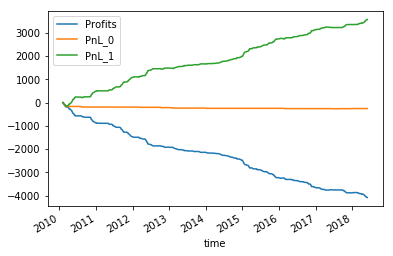

In [26]:
# Reversal
df_print['Reversal'] = df_print.Profits.cumsum() < \
                     df_print.Profits.cumsum().rolling(10).mean()
df_print['Reversal'] = df_print.Reversal.shift(1)

# AntiMart
# AntiMartingale for Non-Reversal Trades ONLY
stratXL = df_print[df_print.Reversal == False]
stratXL.loc[:, 'AntiMart'] = ConLoss(stratXL.Profits)
df_print.loc[df_print.Reversal == False, 'AntiMart'] = stratXL.AntiMart

stratXL = df_print[df_print.Reversal == True]
stratXL.loc[:, 'AntiMart'] = ConLoss(stratXL.Profits)
df_print.loc[df_print.Reversal == True, 'AntiMart'] = stratXL.AntiMart

df_print['AntiMart'].fillna(value=0, inplace=True)

df_print.loc[:, 'AntiMart'] = df_print.AntiMart.shift(1)

# Taking into account the stacking of trades

df_print['Reversal'] = np.where(df_print.ClosePriceTime != df_print.ClosePriceTime.shift(1), 
                                df_print.Reversal, None)
df_print['Reversal'].fillna(method='ffill', inplace=True)

df_print['AntiMart'] = np.where(df_print.ClosePriceTime != df_print.ClosePriceTime.shift(1), 
                                df_print.AntiMart, None)
df_print['AntiMart'].fillna(method='ffill', inplace=True)

# Get no/full reversal trades

df_print['PnL_0'] = np.where(df_print.Reversal,
                             0, df_print.Profits)
df_print['PnL_1'] = np.where(df_print.Reversal,
                             -1*df_print.Profits, 
                             df_print.Profits)

# Plot the equity curves
# Profits - Normal trades
# PnL_0 - No reversal with anti-martingale
# PnL_1 - Full reversal with anti-martingale

plt.figure()
df_print[['Profits', 'PnL_0', 'PnL_1']].cumsum().plot()


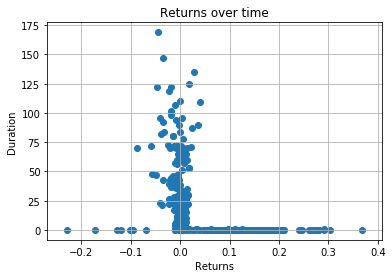

In [27]:
plt.scatter(new_df.AntiMartProfits_1, df_print.Duration)
plt.title("Returns over time")
plt.xlabel("Returns")
plt.ylabel("Duration")
plt.grid(True)
plt.show()

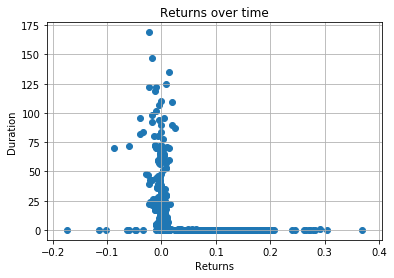

In [28]:
plt.scatter(new_df.AntiMartProfits_2, df_print.Duration)
plt.title("Returns over time")
plt.xlabel("Returns")
plt.ylabel("Duration")
plt.grid(True)
plt.show()

In [29]:
df_print.to_csv('../Results/{}'.format(market.split('/')[-1]))           # Total trades csv
# Strats name to be following this naming structure:
# <metastrat name>-{}

FileNotFoundError: [Errno 2] No such file or directory: '../Results/EURUSD-2010_01_01-2018_06_12.csv'